In [1]:
import matplotlib.pyplot as plt
import json

In [2]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from pts.dataset.repository import get_dataset
from pts.dataset.utils import to_pandas

In [5]:
dataset = get_dataset("m4_hourly", regenerate=False)

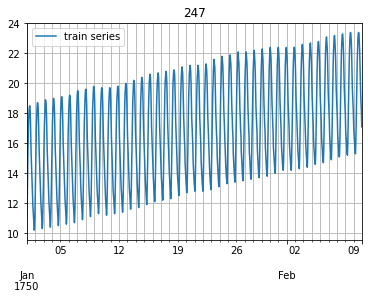

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

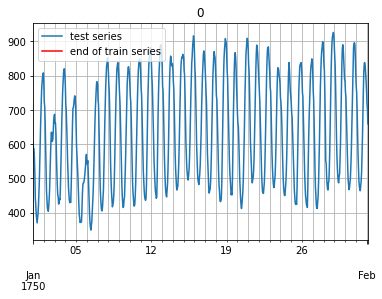

In [7]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

In [8]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 48
Frequency of the time series: H


In [9]:
from pts.model.deepar import DeepAREstimator
from pts.modules import ZeroInflatedNegativeBinomialOutput, PiecewiseLinearOutput
from pts import Trainer

In [12]:
estimator = DeepAREstimator(
    distr_output=PiecewiseLinearOutput(num_pieces=10),
    cell_type='GRU',
    input_size=48,
    num_cells=64,
    num_layers=3,
    dropout_rate=0.2,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    #cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
    #embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=50,
                    learning_rate=1e-5,
                    num_batches_per_epoch=120,
                    batch_size=256,
                    num_workers=8,
                    pin_memory=True,
                   )
)

In [ ]:
predictor = estimator.train(dataset.train)

21it [00:16,  1.45it/s, avg_epoch_loss=nan, epoch=0]    

In [12]:
from pts.evaluation import make_evaluation_predictions, Evaluator

In [13]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [15]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 30490/30490 [00:01<00:00, 23152.64it/s]


In [18]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4.439620313754265,
    "abs_error": 807089.0,
    "abs_target_sum": 1231764.0,
    "abs_target_mean": 1.4428196598416343,
    "seasonal_error": 1.1272178349378457,
    "MASE": 0.8789472000957106,
    "MAPE": 0.30587227335898637,
    "sMAPE": 0.6816909686747539,
    "OWA": NaN,
    "MSIS": 7.28829495943688,
    "QuantileLoss[0.1]": 228315.8,
    "Coverage[0.1]": 0.0042929766199690765,
    "QuantileLoss[0.2]": 422650.8,
    "Coverage[0.2]": 0.01732535257461463,
    "QuantileLoss[0.3]": 586642.4,
    "Coverage[0.3]": 0.042479970013587595,
    "QuantileLoss[0.4]": 716891.6,
    "Coverage[0.4]": 0.08317012603663966,
    "QuantileLoss[0.5]": 807089.0,
    "Coverage[0.5]": 0.14288174108607035,
    "QuantileLoss[0.6]": 854345.2,
    "Coverage[0.6]": 0.2176439582064377,
    "QuantileLoss[0.7]": 842037.0,
    "Coverage[0.7]": 0.3306306517359322,
    "QuantileLoss[0.8]": 755156.7999999999,
    "Coverage[0.8]": 0.48669352949444783,
    "QuantileLoss[0.9]": 547328.7999999999,
    "Cove

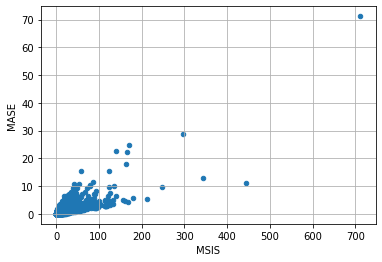

In [19]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()